This notebook contains material reminding you of the process of correcting data taken by a CCD. Most of this material was covered back in Lab 4.

In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline
rc('figure', figsize=(12.0, 9.0)) # This line changes the default figure size to be 12x9

In [ ]:
path = 'example_data/' #Filepath to the folder containing your data
biases = [] #initializes an empty list to put the bias data in
for i in range(1,11): #loop over the file indices corresponding to bias data
    biases.append(fits.getdata(path+'tBias'+"0"*(8-len(str(i)))+str(i) +'.fit', ext=0).astype(np.int))
    #The above line reads in the bias frames. This should look similar to past .fit loading,
    #where in this case the files have the naming format tBias000000XX.fit
    #The ext=0 argument tells Python which part of the fit file to load in (i.e., which extension of the file)
    #The final .astype(int) converts the loaded data to integers (by default, Python generally reads in data as strings)
    
avg_bias = np.asarray(biases).mean(axis=0) #Creates an average bias frame to subtract from all measurements    

In [10]:
#Similar code to the above, but for loading the lamp data, Sun data, and then backgrounds for each

lamp_on  = [] 
lamp_off = []

sun_on  = []
sun_off = []

for i in range(11,16):
    zeros = (8-len(str(i)))*'0'
    sun_on.append(fits.getdata(path+'t'+zeros+'{}.fit'.format(i), ext=0).astype(np.int))
    
for i in range(16,21):
    zeros = (8-len(str(i)))*'0'
    sun_off.append(fits.getdata(path+'t'+zeros+'{}.fit'.format(i), ext=0).astype(np.int))
    
for i in range(21,24):
    zeros = (8-len(str(i)))*'0'
    lamp_on.append(fits.getdata(path+'t'+zeros+'{}.fit'.format(i), ext=0).astype(np.int))
    
for i in range(24,27):
    zeros = (8-len(str(i)))*'0'
    lamp_off.append(fits.getdata(path+'t'+zeros+'{}.fit'.format(i), ext=0).astype(np.int))
    
    
    

In [12]:
#Then we correct our data by subtracting off the mean bias frame from each individual observation

#The format employed here is a simple form of Python's "List Comprehension"
#This is one of Python's more powerful features, which allows you to fill elements of a list
#in a fashion much like a for loop, but in a single line. Beyond compactness, Python can
#actually handle running this more efficiently than the same process in a proper for loop.

#Examine the syntax used in the list comprehension here to see how it compares to the more
#familiar syntax used in for loops. If the way this works is still unclear, you can ask your
#GSI for further explanation.
lamp_on_sub_bias = [lamp - avg_bias for lamp in lamp_on] 
lamp_off_sub_bias = [lamp - avg_bias for lamp in lamp_off]
sun_on_sub_bias = [sun - avg_bias for sun in sun_on]
sun_off_sub_bias = [sun - avg_bias for sun in sun_off]

#Now we take the average bias-corrected background frame for the lamp and Sun
avg_lamp_off = np.asarray(lamp_off_sub_bias).mean(axis=0) #As we've used previously, np.asarray() turns a list into an array. Then, an array can be acted on by .mean(axis=0) to take the mean along the specified axis
avg_sun_off = np.asarray(sun_off_sub_bias).mean(axis=0)

In [14]:
#Next we subtract off the background from each of the lamp and Sun datasets, again using list comprehension
lamp_corrected = [lamp_on - avg_lamp_off for lamp_on in lamp_on_sub_bias]
sun_corrected  = [sun_on - avg_sun_off for sun_on in sun_on_sub_bias]

#Finally, we use .mean() again to get the average lamp and sun observations
avg_lamp = np.asarray(lamp_corrected).mean(axis=0)
avg_sun = np.asarray(sun_corrected).mean(axis=0)

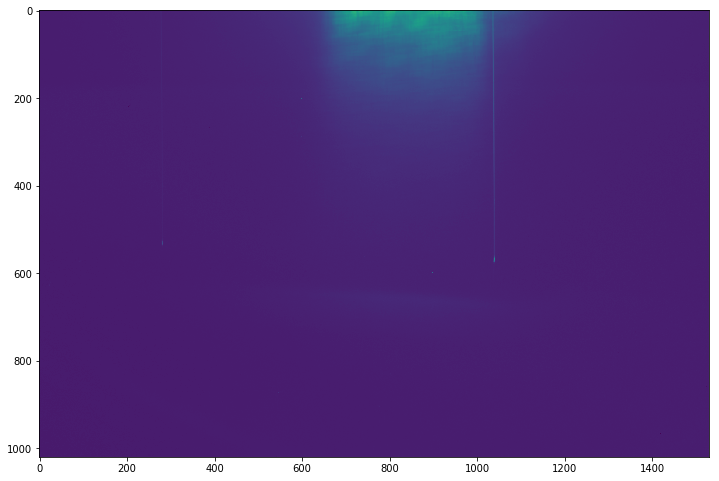

In [17]:
#plt.imshow() plots a 2x2 array of numbers into a plane where color represents the value of each array element
#The default colormap is called 'viridis,' where darker/bluer values are low, while brighter/yellower values are high
plt.imshow(avg_lamp) 
plt.show()

#This allows us to visualize where on the CCD the spectrum landed, based on where the bright lines appear
#This will then enable us to 'crop' the part of the array containing the spectrum and work only with that

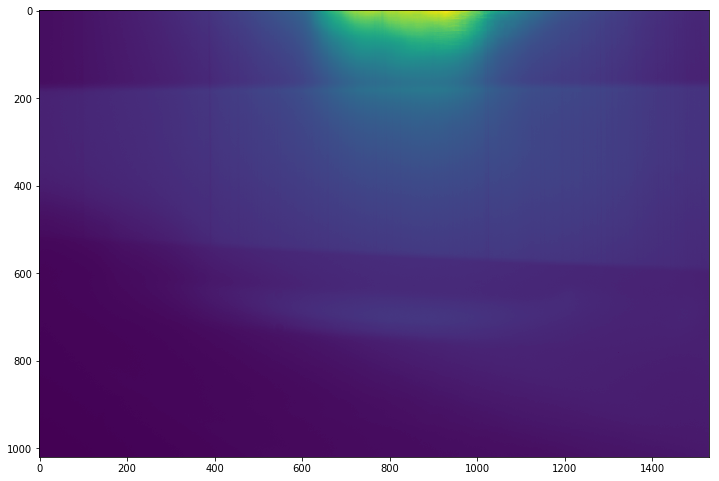

In [18]:
plt.imshow(avg_sun)
plt.show()

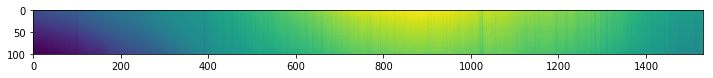

In [19]:
#Now we use array indexing to examine a chosen part of the spectrum to see if it contains the data we need (i.e., spectral lines).
plt.imshow(avg_sun[400:500,:])

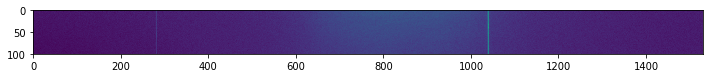

In [20]:
plt.imshow(avg_lamp[400:500,:])

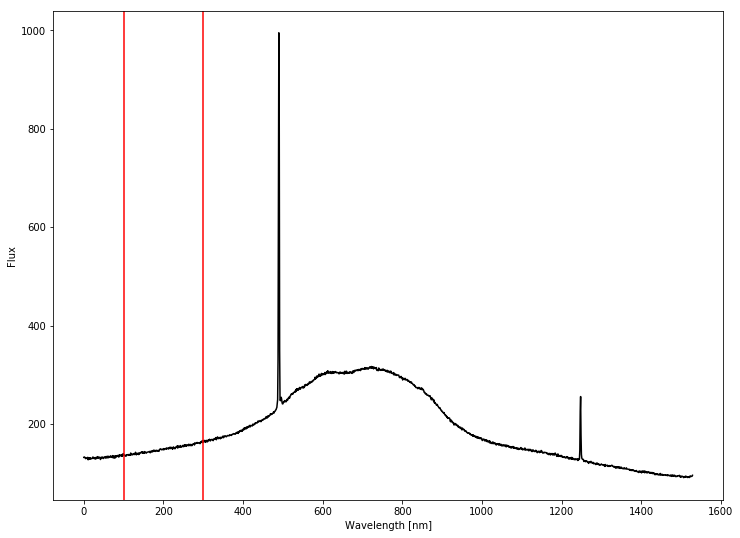

In [26]:
lamp_good = np.asarray(avg_lamp[400:500,:]).mean(axis=0) #Averages the value along each column in the region that our spectra look relatively free of contamination
sun_good  = np.asarray(avg_sun[400:500,:]).mean(axis=0)

example_lines = [100, 300] #These are for example purposes, not actual wavelengths for the lamp

plt.plot(np.flip(np.arange(len(lamp_good)),0), lamp_good, 'k-') #np.flip(~~~) reverses the array inside it.
for line in example_lines:
    plt.axvline(line,color='r')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux')
plt.show()

# The x-axis wavelength values are clearly incorrect. They need to be stretched and shifted so that the lines
# from the discharge tube match with their actual values. This correction can then also be applied to our solar spectra